# Experiment 1: K-Means on Original Data
This notebook replicates `Exp1.py`: run K-Means on the breast cancer dataset, compare kmeans++ vs random init, pick k via elbow, silhouette, and gap statistic, and report internal/external metrics plus confusion matrices.

In [1]:
# Setup and Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
import part3

# Plot style
sns.set(style="whitegrid")

In [2]:
# Load and Standardize Dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [3]:
# Helper: Within-Cluster Sum of Squares

def _within_cluster_ss(X, labels, centroids):
    ss = 0.0
    for i in range(centroids.shape[0]):
        pts = X[labels == i]
        if pts.size == 0:
            continue
        diff = pts - centroids[i]
        ss += np.sum(diff * diff)
    return ss

In [4]:
# Helper: Gap Statistic and Optimal k Selection

def gap_statistic(X, k_max=10, B=10, init="kmeans++", max_iter=300, tol=1e-4, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    Wks = np.zeros(k_max)
    Wkbs = np.zeros((k_max, B))

    for k in range(1, k_max + 1):
        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km.fit(X)
        Wks[k - 1] = _within_cluster_ss(X, km.labels_, km.centroids_)

        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n_samples, n_features))
            km_b = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
            np.random.seed(int(rng.integers(0, 2**32 - 1)))
            km_b.fit(Xb)
            Wkbs[k - 1, b] = _within_cluster_ss(Xb, km_b.labels_, km_b.centroids_)

    logWks = np.log(Wks)
    logWkbs = np.log(Wkbs)
    gaps = np.mean(logWkbs, axis=1) - logWks
    sk = np.sqrt(1 + 1.0 / B) * np.std(logWkbs, axis=1)
    return gaps, sk


def select_gap_k(gaps, sk):
    k_vals = np.arange(1, len(gaps) + 1)
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            return k_vals[i]
    return k_vals[-1]

In [5]:
# Run KMeans Across k Values

def run_kmeans_series(X, y_true, k_values, init_method, tol=1e-4, max_iter=300, random_state=42):
    rng = np.random.default_rng(random_state)
    records = {
        "inertia": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "time": [],
        "iterations": [],
        "labels": []
    }

    for k in k_values:
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km = KMeans(k=k, init=init_method, max_iter=max_iter, tol=tol)
        start = time.time()
        km.fit(X)
        elapsed = time.time() - start
        labels = km.labels_

        records["inertia"].append(km.inertia_)
        records["time"].append(elapsed)
        records["iterations"].append(km.iterations_)

        if k > 1:
            sil, _ = part3.silhouette_score(X, labels)
            dbi = part3.davies_bouldin_index(X, labels)
            chi = part3.calinski_harabasz_index(X, labels)
        else:
            sil, dbi, chi = np.nan, np.nan, np.nan

        records["silhouette"].append(sil)
        records["davies_bouldin"].append(dbi)
        records["calinski_harabasz"].append(chi)
        records["wcss"].append(part3.within_cluster_sum_of_squares(X, labels))
        records["labels"].append(labels)

        records["ari"].append(part3.adjusted_rand_index(y_true, labels))
        records["nmi"].append(part3.normalized_mutual_information(y_true, labels))
        records["purity"].append(part3.purity_score(y_true, labels))

    return records

In [6]:
# Elbow and Silhouette Heuristics

def pick_elbow_k(k_values, inertia_values):
    inertia_arr = np.array(inertia_values)
    if len(inertia_arr) < 3:
        return k_values[len(k_values) // 2]
    second = np.diff(inertia_arr, n=2)
    idx = np.argmax(second) + 1
    return k_values[idx]


def best_silhouette_k(k_values, silhouette_values):
    return k_values[int(np.nanargmax(silhouette_values))]

In [7]:
# Plot Internal Metrics and Convergence

def plot_metric_curves(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["inertia"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow (Inertia)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["silhouette"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.title("Silhouette Analysis")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_internal_metrics(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["davies_bouldin"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["calinski_harabasz"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_convergence(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["iterations"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Iterations")
    plt.title("Convergence speed (iterations)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["time"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Time (s)")
    plt.title("Convergence speed (time)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Compute and Plot Gap Statistic

def plot_gap(k_values, gaps, sk, optimal_k):
    plt.figure(figsize=(8, 5))
    plt.errorbar(k_values, gaps, yerr=sk, fmt="o-", capsize=5, label="Gap")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal k={optimal_k}")
    plt.xlabel("k")
    plt.ylabel("Gap statistic")
    plt.title("Gap Statistic")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_gap_and_plot(X, max_k, init="kmeans++", B=10):
    gaps, sk = gap_statistic(X, k_max=max_k, init=init, B=B, random_state=42)
    gap_k = select_gap_k(gaps, sk)
    plot_gap(np.arange(1, len(gaps) + 1), gaps, sk, gap_k)
    print(f"Gap statistic optimal k={gap_k}")
    return gaps, sk, gap_k

In [9]:
# External Metrics at k=2 with Confusion Matrix

def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def report_k2_confusion(results, k_values, y_true):
    k_report = 2
    if k_report not in k_values:
        print("k=2 not in k_values; skipping confusion matrices.")
        return
    idx = k_values.index(k_report)
    for init_method, res in results.items():
        print(
            f"Init={init_method}, k={k_report}: "
            f"ARI={res['ari'][idx]:.3f}, NMI={res['nmi'][idx]:.3f}, Purity={res['purity'][idx]:.3f}, "
            f"WCSS={res['wcss'][idx]:.1f}, Silhouette={res['silhouette'][idx]:.3f}"
        )
        cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, res["labels"][idx])
        title = f"Confusion Matrix (init={init_method}, k={k_report})"
        plot_confusion(cm, true_classes, pred_clusters, title)

Init=kmeans++: elbow k=3, silhouette-opt k=2
Init=random: elbow k=3, silhouette-opt k=2


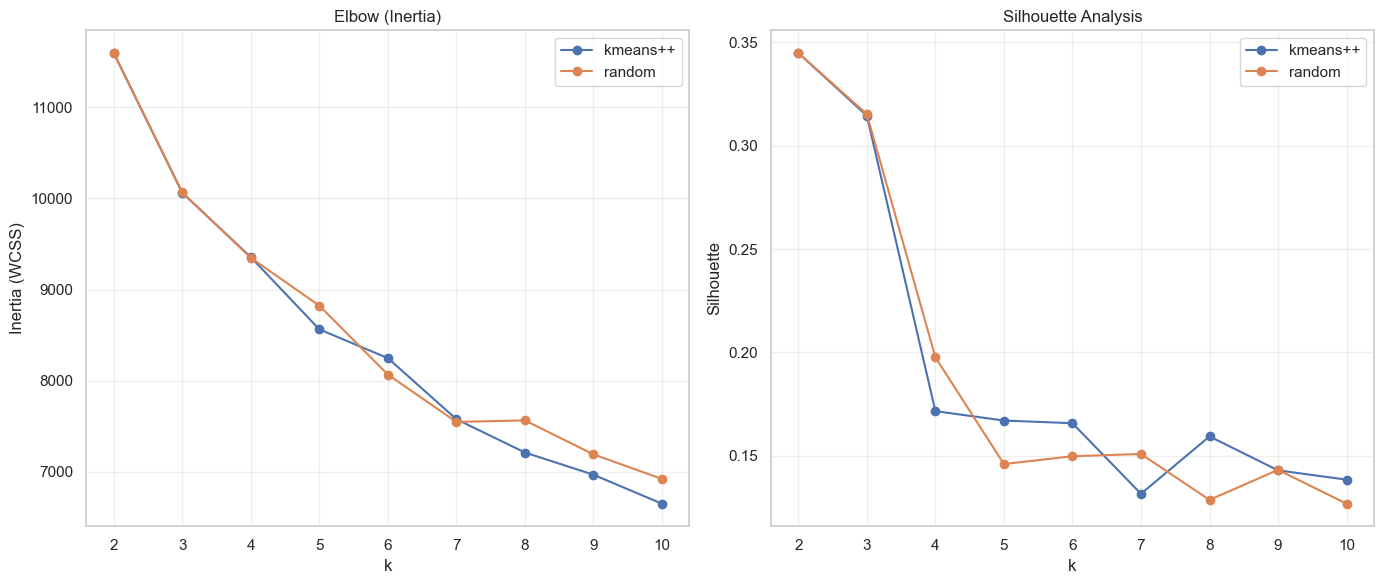

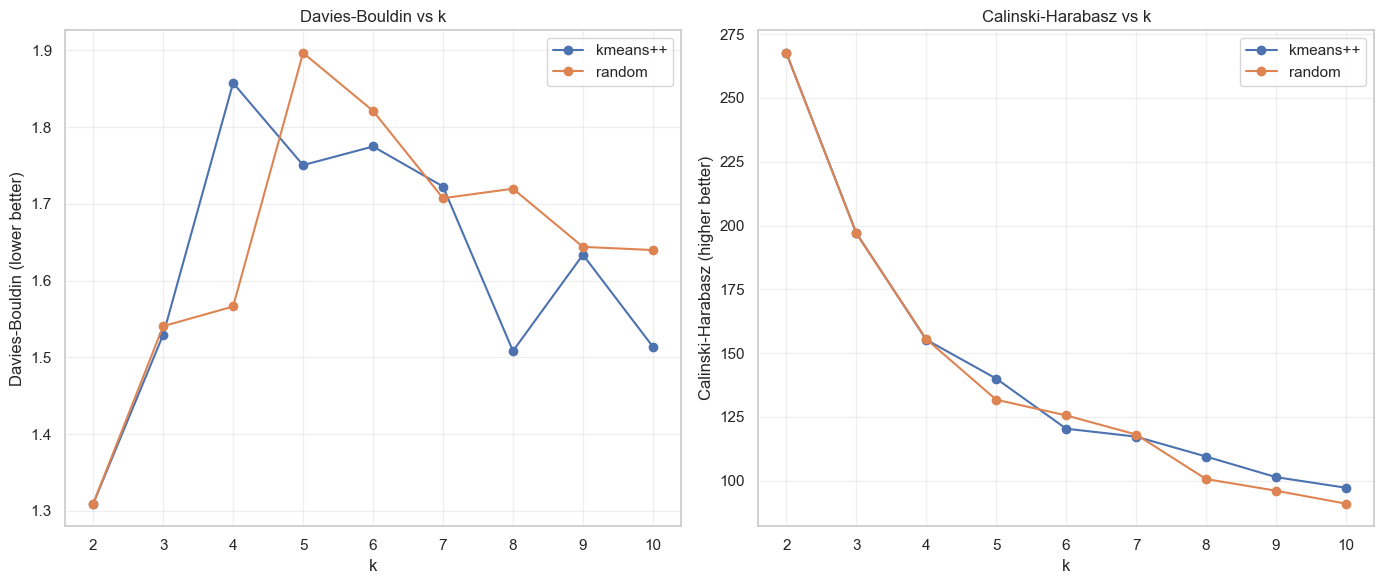

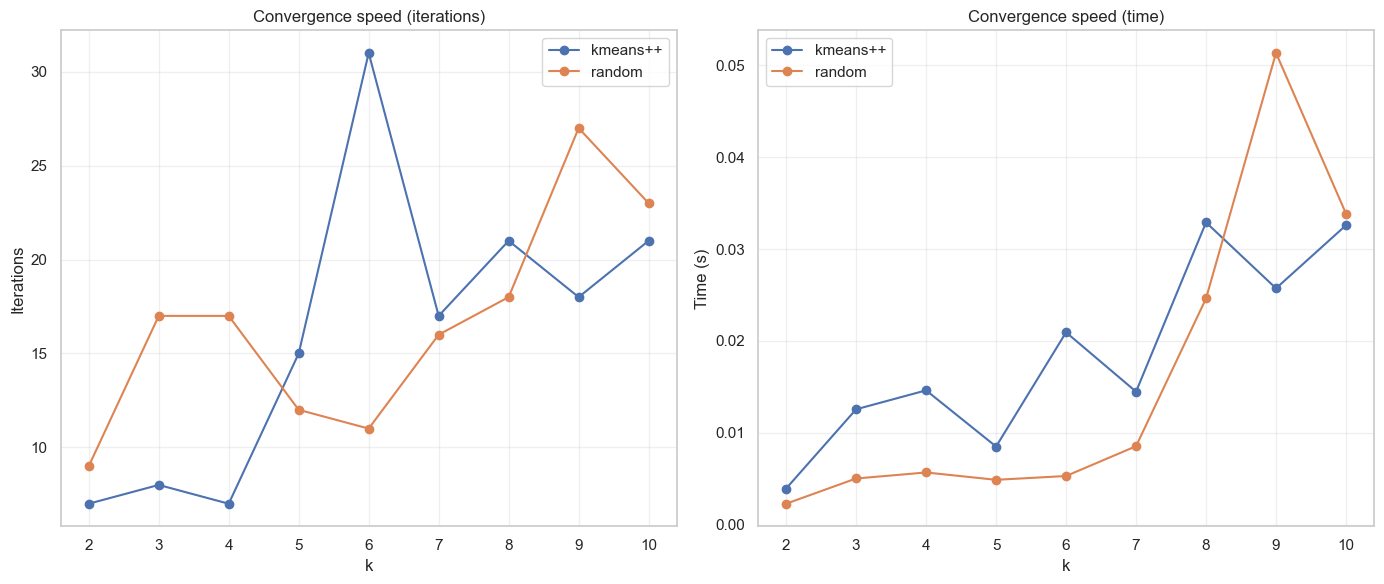

Computing gap statistic (kmeans++ init)...


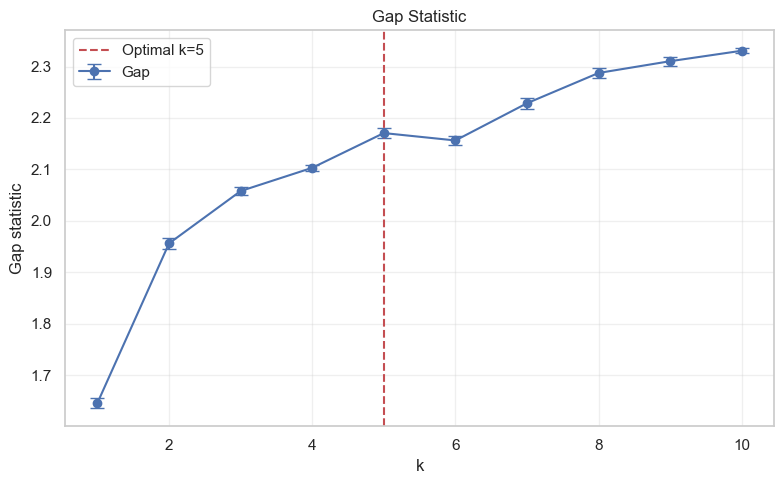

Gap statistic optimal k=5
Init=kmeans++, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


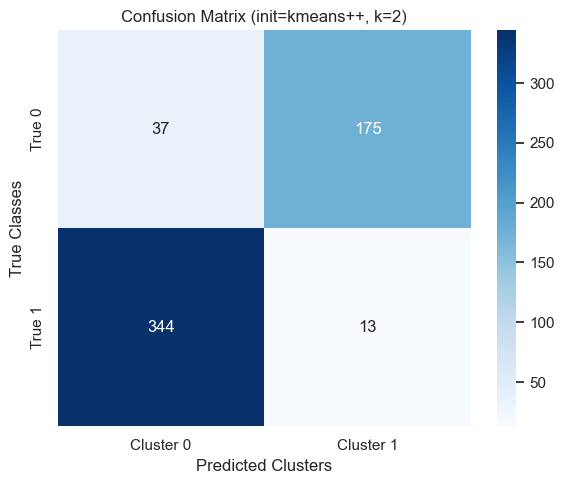

Init=random, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


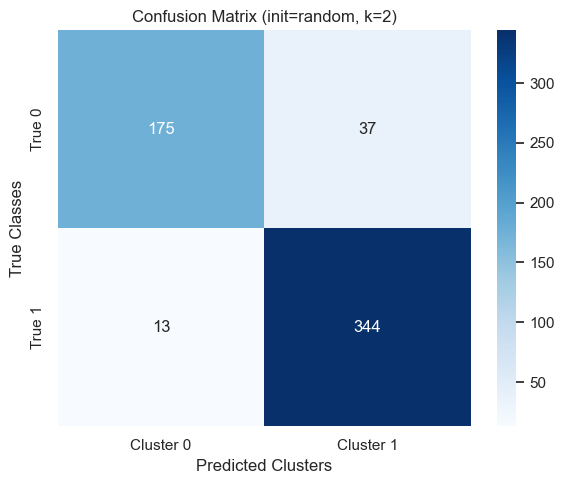

In [10]:
# Run the experiment end-to-end
k_values = list(range(2, 11))

results = {}
for init_method in ["kmeans++", "random"]:
    res = run_kmeans_series(X, y_true, k_values, init_method)
    results[init_method] = res
    elbow_k = pick_elbow_k(k_values, res["inertia"])
    best_sil_k = best_silhouette_k(k_values, res["silhouette"])
    print(f"Init={init_method}: elbow k={elbow_k}, silhouette-opt k={best_sil_k}")

plot_metric_curves(k_values, results)
plot_internal_metrics(k_values, results)
plot_convergence(k_values, results)

print("Computing gap statistic (kmeans++ init)...")
gaps, sk, gap_k = compute_gap_and_plot(X, max_k=max(k_values), init="kmeans++", B=10)

report_k2_confusion(results, k_values, y_true)